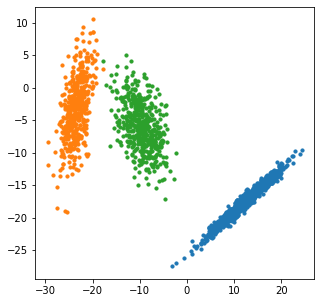

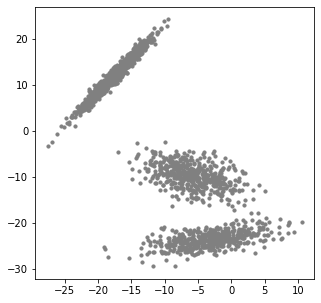

In [37]:
import numpy as np 
import numpy.matlib 
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
# Gaussian 분포의 확률 분포 함수를 계산하기 위해서 가져온거

# rotation
r1 = 10*(np.random.rand(2,2) - 0.5)
r2 = 10*(np.random.rand(2,2) - 0.5)
r3 = 10*(np.random.rand(2,2) - 0.5)

# translation
t1 = 50*(np.random.rand(2,1) - 0.5)
t2 = 50*(np.random.rand(2,1) - 0.5)
t3 = 50*(np.random.rand(2,1) - 0.5)

X1 = np.random.randn(2,1000)
X1 = r1.dot(X1) + t1

X2 = np.random.randn(2,500)
X2 = r2.dot(X2) + t2

X3 = np.random.randn(2,500)
X3 = r3.dot(X3) + t3

plt.figure(figsize = (5,5))
plt.scatter(X1[0,:],X1[1,:], s = 10)
plt.scatter(X2[0,:],X2[1,:], s = 10)
plt.scatter(X3[0,:],X3[1,:], s = 10)

X = np.hstack([X1, X2, X3])
np.random.shuffle(X)

plt.figure(figsize = (5,5))
plt.scatter(X[0,:],X[1,:],s = 10,color = "gray")

(0.0, 1.0)

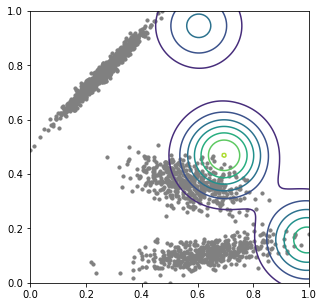

In [42]:
K = 3 # cluster의 개수
maxIter = 10 # 최대 몇번 iteration을 반복할건지

# initial parameter
D,N = X.shape

# normalization, [0, 1]
Xmin = np.min(X, axis = 1)
Xmax = np.max(X, axis = 1)
X = (X - np.matlib.repmat(Xmin.reshape(-1,1), 1, N)) / np.matlib.repmat((Xmax - Xmin).reshape(-1,1), 1, N)

# random initialize
pi = np.random.rand(K)
pi = pi / np.sum(pi)
mu = np.random.rand(D,K)
sigma = np.zeros((D,D,K))
for k in range(0,K):
    sigma[:,:,k] = 1e-2*np.identity(D)
    
# draw contour
u = np.linspace(-2,5,1000) # 가로축을 쪼개는 벡터
v = np.linspace(-2,5,1000) # 세로축을 쪼개는 벡터
uu, vv = np.meshgrid(u, v)

mog_pdf = np.zeros(uu.shape)
for k in range(0,K):
    pdf = pi[k]*multivariate_normal.pdf(np.hstack([uu.reshape(-1,1), vv.reshape(-1,1)]),mu[:,k],sigma[:,:,k])
    mog_pdf += pdf.reshape(1000,1000)
    
plt.figure(figsize = (5,5))
plt.scatter(X[0,:],X[1,:],s = 10,color = "gray")
plt.contour(uu,vv,mog_pdf) # contour = 등고선
plt.xlim([np.min(X[0,:]),np.max(X[0,:])])
plt.ylim([np.min(X[1,:]),np.max(X[1,:])])

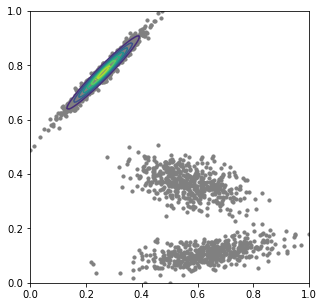

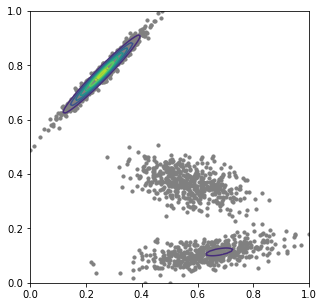

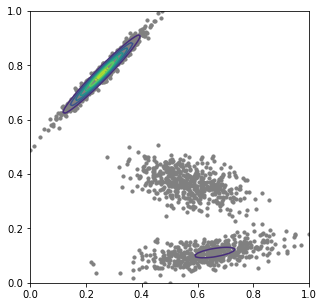

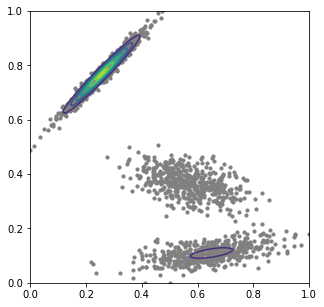

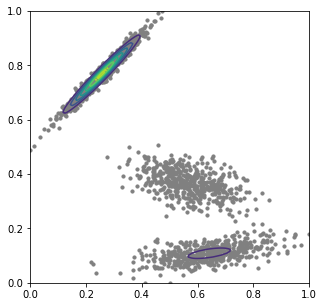

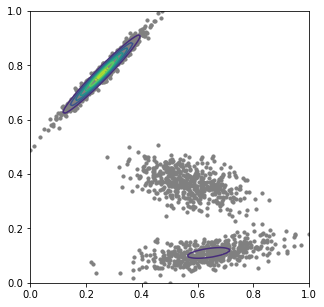

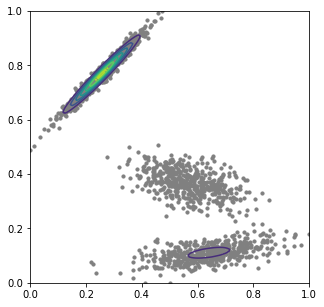

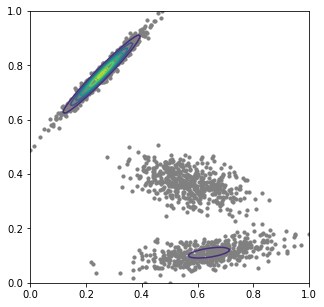

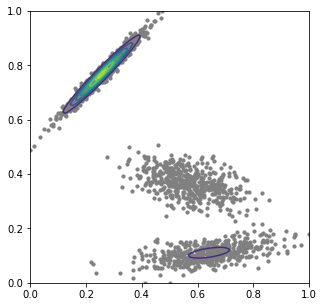

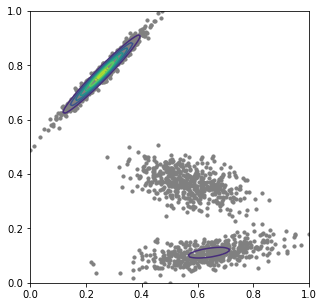

In [43]:
# 변수 선언
Num = np.zeros(K)
gamma = np.zeros((K,N))

for iter in range(0,maxIter):
    # E-step: 주어진 샘플, 파라미터 => responsibility를 계산
    for k in range(0,K):
        gamma[k,:] = pi[k]*multivariate_normal.pdf(X.T,mu[:,k],sigma[:,:,k])
    gamma = gamma / np.sum(gamma, axis = 0)

    # M-step: 주어진 샘플, responsibility => 파라미터를 계산
    for k in range(0,K):
        Num[k] = np.sum(gamma[k,:]) # np.sum = 전체 샘플에 대한 합
        pi[k] = Num[k] / N

        mu[:,k] = np.sum(np.matlib.repmat(gamma[k,:].reshape(1,N),D,1) * X, axis = 1) / Num[k]

        # residual = (X - mu[k]) = D x N
        residual = (X - np.matlib.repmat(mu[:,k].reshape(D,1),1,N))    
        # gamma_residual = gamma[k,:]*(X - mu[k]) = D x N
        gamma_residual = np.matlib.repmat(gamma[k,:],D,1) * residual
        sigma[:,:,k] = np.zeros((D,D))
        for n in range(0,N):
            sigma[:,:,k] += gamma_residual[:,n].reshape(D,1).dot(residual[:,n].reshape(D,1).T)
        sigma[:,:,k] /= Num[k]    

    # draw contour
    mog_pdf = np.zeros(uu.shape)
    for k in range(0,K):
        pdf = multivariate_normal.pdf(np.hstack((uu.reshape(-1,1),vv.reshape(-1,1))), mean = mu[:,k], cov = sigma[:,:,k])
        mog_pdf += pi[k] * pdf.reshape(1000,1000)

    plt.figure(figsize = (5,5))
    plt.scatter(X[0,:],X[1,:],s = 10,color = "gray")
    plt.contour(uu,vv,mog_pdf)
    plt.xlim([np.min(X[0,:]),np.max(X[0,:])])
    plt.ylim([np.min(X[1,:]),np.max(X[1,:])])    

In [ ]:
#     gamma[k,:] = 1 x N
#     X = D x N
    
#     np.matlib.repmat(gamma[k,:].reshape(1,N),D,1) = D x N
#     np.matlib.repmat(gamma[k,:].reshape(1,N),D,1) * X = D x N
#     np.sum(np.matlib.repmat(gamma[k,:].reshape(1,N),D,1) * X, axis = 1) = D x 1
#     np.sum(np.matlib.repmat(gamma[k,:].reshape(1,N),D,1) * X, axis = 1) / Num[k] = D x 1

(0.0, 1.0)

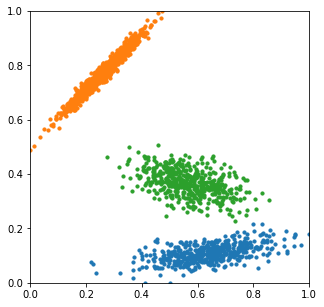

In [44]:
label = np.argmax(gamma, axis = 0)

plt.figure(figsize = (5,5))
for k in range(0,K):
    plt.scatter(X[0,label == k],X[1,label == k],s = 10)
plt.xlim([np.min(X[0,:]),np.max(X[0,:])])
plt.ylim([np.min(X[1,:]),np.max(X[1,:])])

(0.0, 1.0)

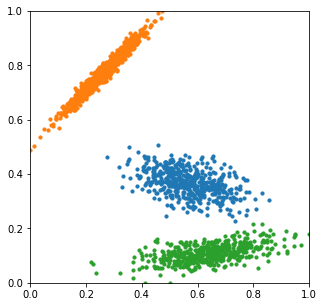

In [60]:
from sklearn.mixture import GaussianMixture
# mixture of Gaussian (MoG)
# Gaussian mixture model (GMM)
model = GaussianMixture(n_components = K)
labels = model.fit_predict(X.T)

plt.figure(figsize = (5,5))
for k in range(0,K):
    plt.scatter(X[0,labels == k],X[1,labels == k],s = 10)
plt.xlim([np.min(X[0,:]),np.max(X[0,:])])
plt.ylim([np.min(X[1,:]),np.max(X[1,:])])